In [ ]:
#Loading the packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from tqdm import tqdm
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import timm
from sklearn import svm
from sklearn.metrics import accuracy_score
from google.colab import drive
from PIL import Image

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class CardsDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = ImageFolder(data, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    @property
    def classes(self):
        return self.data.classes

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = CardsDataset(data, transform)

In [ ]:
dataset = CardsDataset(
    data='/content/drive/MyDrive/data/train'
)
len(dataset)

7624

Label: 6
Image size: (224, 224)


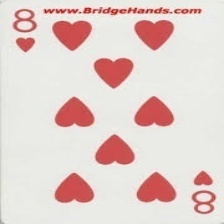

In [ ]:
image, label = dataset[1000]
print("Label:", label)
print("Image size:", image.size)
image

In [ ]:
for image, label in dataset:
    break

dataloader = DataLoader(dataset, batch_size = 32, shuffle = True)

In [ ]:
class CardsClassifier(nn.Module):
    def __init__(self, num_classes=53, input_size=224):
        super(CardsClassifier, self).__init__()

        # Loading the pre-trained EfficientNet-B0 model
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)

        self.base_model.conv_stem = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=2, bias=False)

        self.base_model.global_pool = nn.AdaptiveAvgPool2d(1)
        self.base_model.num_classes = 1000
        self.base_model.classifier = nn.Identity()
        # Get the number of output features from the base model
        enet_out_size = self.base_model.num_features

        self.classifier = nn.Linear(enet_out_size, num_classes)

    def forward(self, x):
        x = self.base_model(x)
        output = self.classifier(x.view(x.size(0), -1))
        return output


In [ ]:
model = CardsClassifier(num_classes=53)

In [ ]:
train_folder = '/content/drive/MyDrive/data/train/'
valid_folder = '/content/drive/MyDrive/data/valid/'
test_folder = '/content/drive/MyDrive/data/test/'

train_dataset = CardsDataset(train_folder, transform=transform)
val_dataset = CardsDataset(valid_folder, transform=transform)
test_dataset = CardsDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
model = CardsClassifier(num_classes=53)
model.to(device)
loss_calc = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store training and validation losses
train_losses = []
val_losses = []

# Training Function
def train(model, train_loader, optimizer, loss_calc, device):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc="Training Loop"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_calc(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    return train_loss

# Validation Function
def validate(model, val_loader, loss_calc, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation Loop'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_calc(outputs, labels)
            running_loss += loss.item() * labels.size(0)

    val_loss = running_loss / len(val_loader.dataset)
    return val_loss

epochs = 8

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

for epoch in range(epochs):
    train_loss = train(model, train_loader, optimizer, loss_calc, device)
    val_loss = validate(model, val_loader, loss_calc, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    scheduler.step()

Validation Loop: 100%|██████████| 9/9 [00:01<00:00,  8.54it/s]


Epoch 1/8 - Train Loss: 1.6510, Validation Loss: 0.4070


Validation Loop: 100%|██████████| 9/9 [00:01<00:00,  8.72it/s]


Epoch 2/8 - Train Loss: 0.5144, Validation Loss: 0.2310


Validation Loop: 100%|██████████| 9/9 [00:01<00:00,  8.69it/s]


Epoch 3/8 - Train Loss: 0.2906, Validation Loss: 0.1429


Validation Loop: 100%|██████████| 9/9 [00:01<00:00,  7.80it/s]


Epoch 4/8 - Train Loss: 0.2242, Validation Loss: 0.1909


Validation Loop: 100%|██████████| 9/9 [00:01<00:00,  7.53it/s]


Epoch 5/8 - Train Loss: 0.1596, Validation Loss: 0.0620


Validation Loop: 100%|██████████| 9/9 [00:01<00:00,  8.40it/s]


Epoch 6/8 - Train Loss: 0.0567, Validation Loss: 0.0664


Validation Loop: 100%|██████████| 9/9 [00:01<00:00,  8.60it/s]


Epoch 7/8 - Train Loss: 0.0299, Validation Loss: 0.0336


Validation Loop: 100%|██████████| 9/9 [00:01<00:00,  8.92it/s]

Epoch 8/8 - Train Loss: 0.0162, Validation Loss: 0.0255


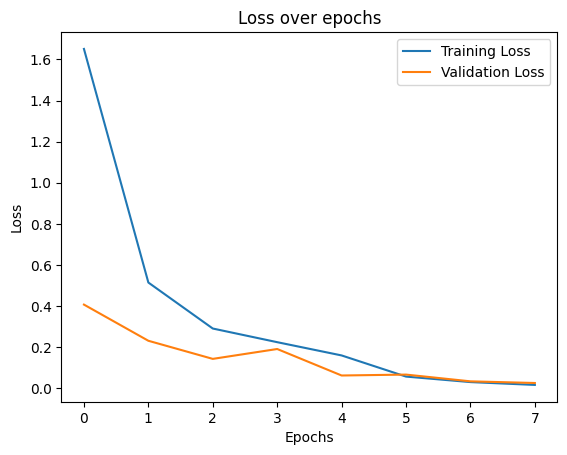

In [ ]:
# Plotting
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title("Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    return image, transform(image).unsqueeze(0)

def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)
    return probs.cpu().numpy().flatten()

def visualize_pred(original_image, probs, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14,7))
    axarr[0].imshow(original_image)
    axarr[0].axis("off")

    axarr[1].barh(class_names, probs)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0,1)

    plt.tight_layout()
    plt.show()

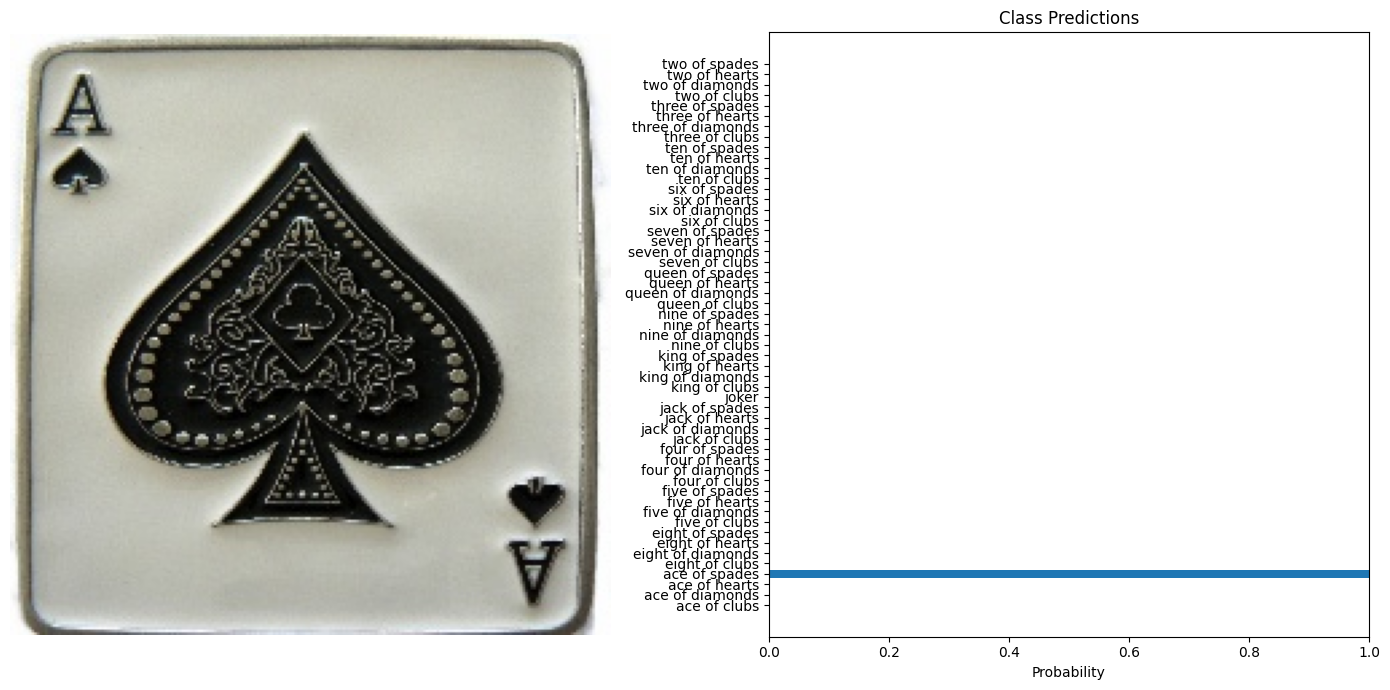

In [ ]:
image_path = "/content/drive/MyDrive/data/test/ace of spades/2.jpg"  # Replace with the path to your image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
original_image, image_tensor = preprocess_image(image_path, transform)

probs = predict(model, image_tensor, device)

# Visualize the prediction
class_names = dataset.classes
visualize_pred(original_image, probs, class_names)

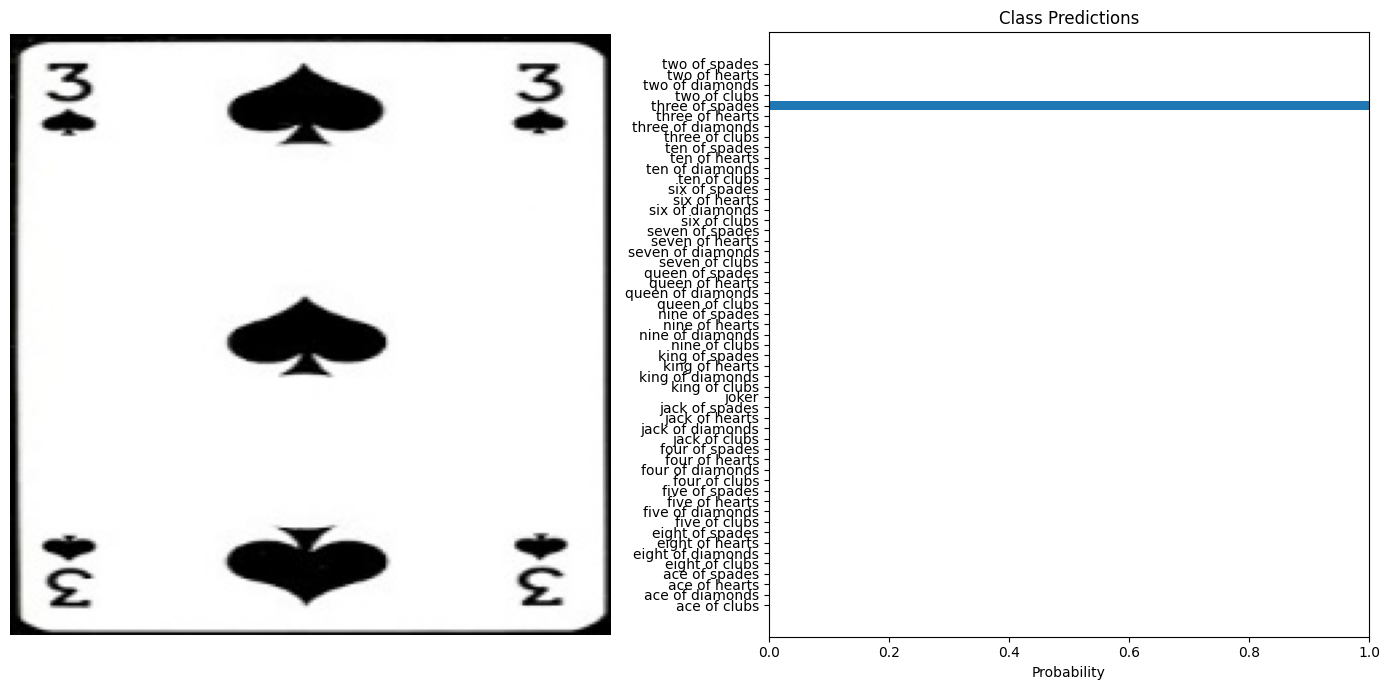

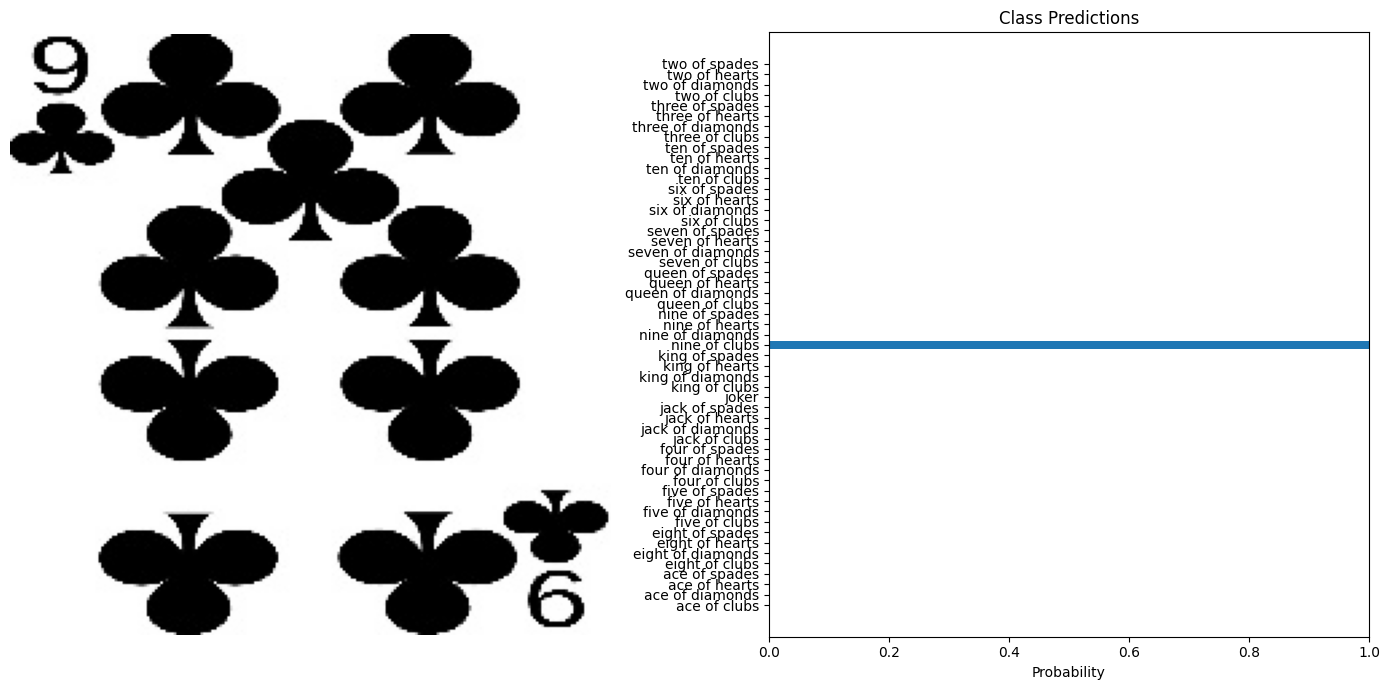

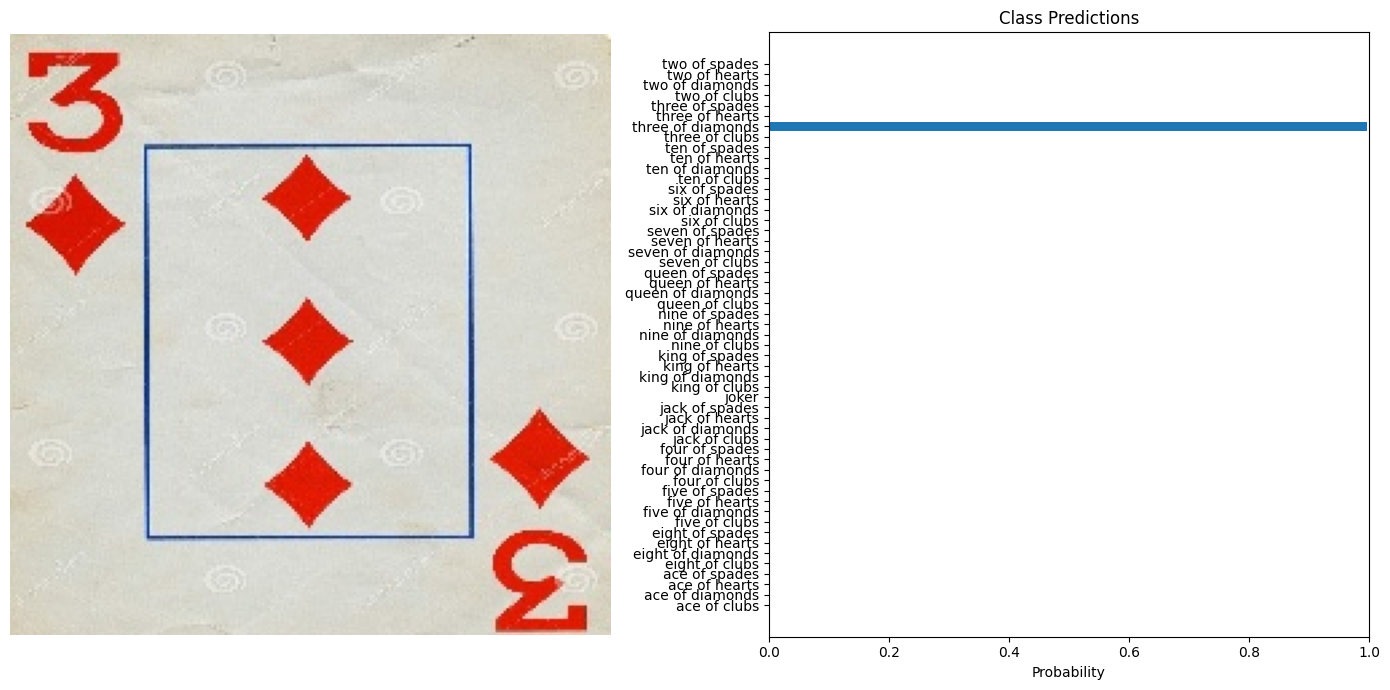

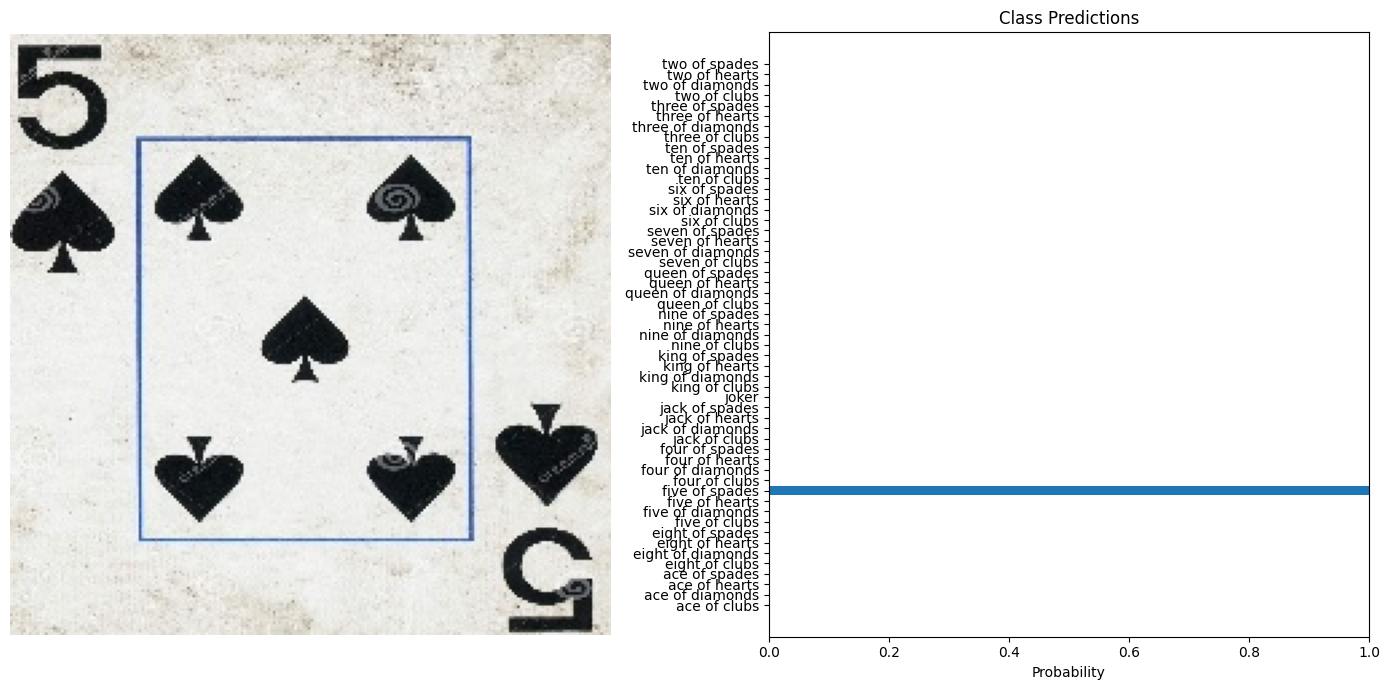

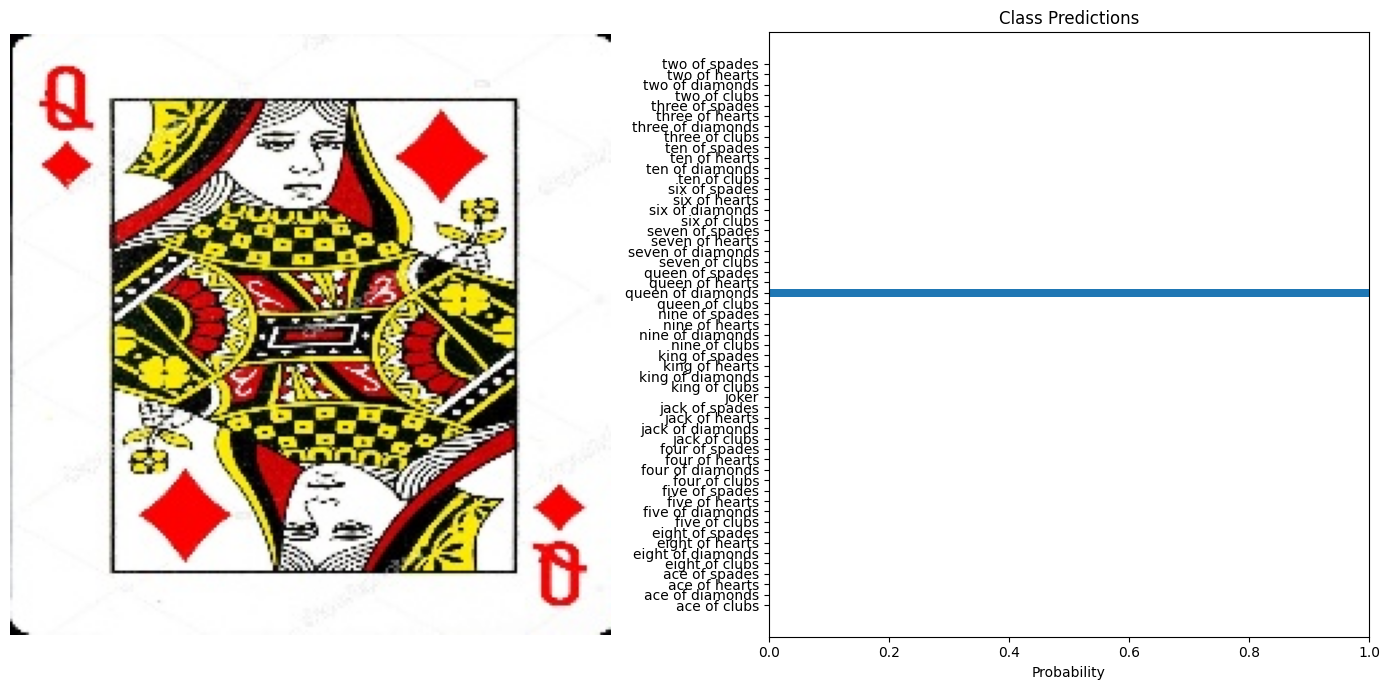

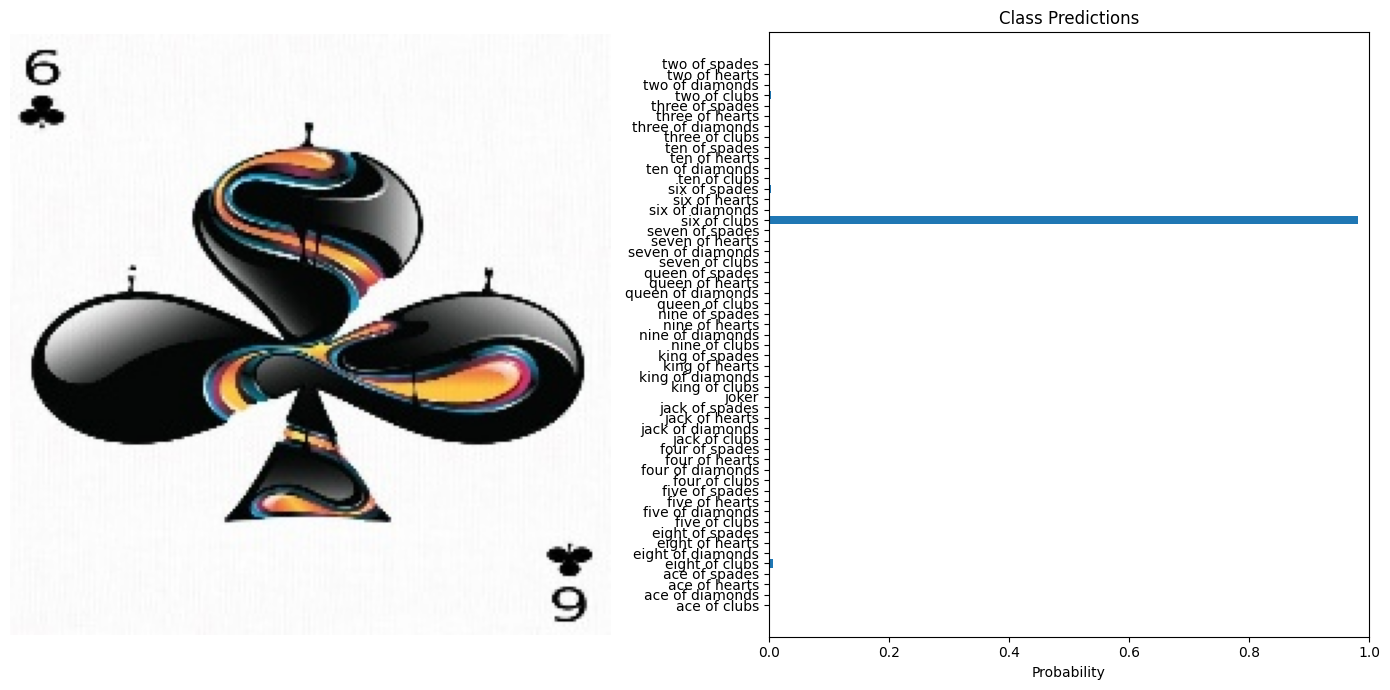

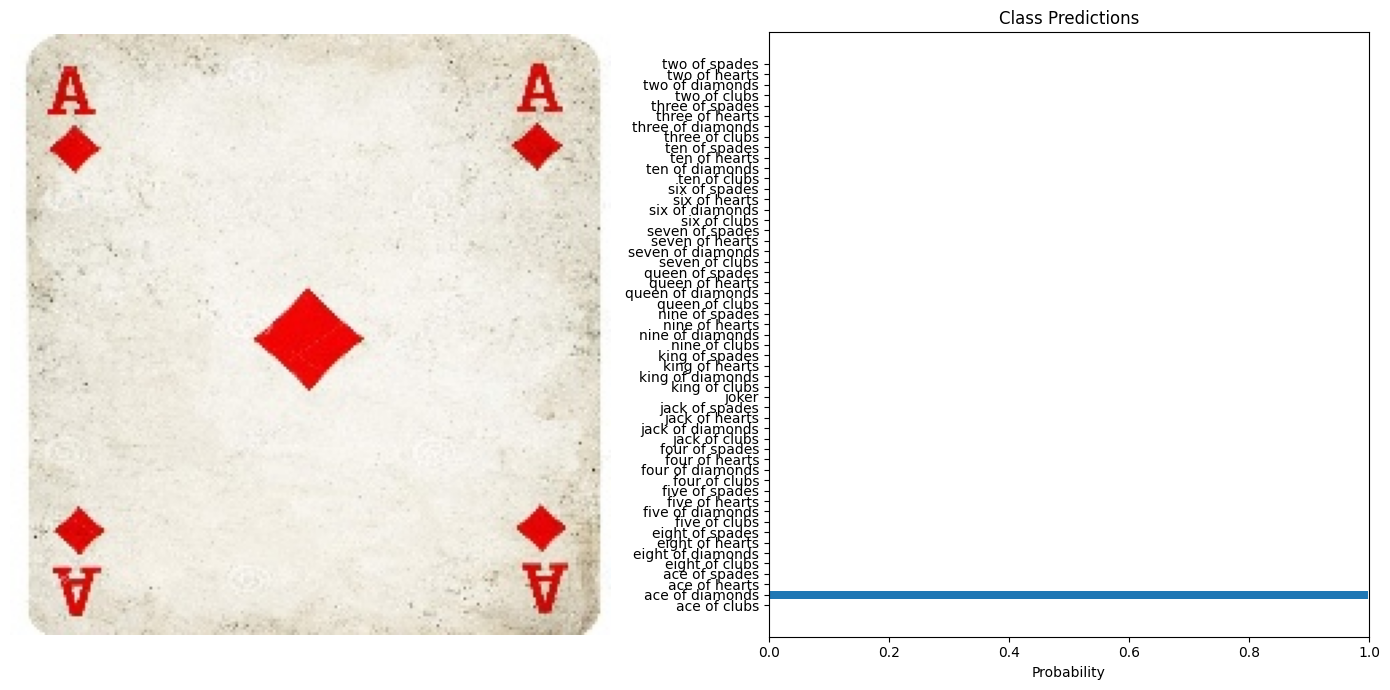

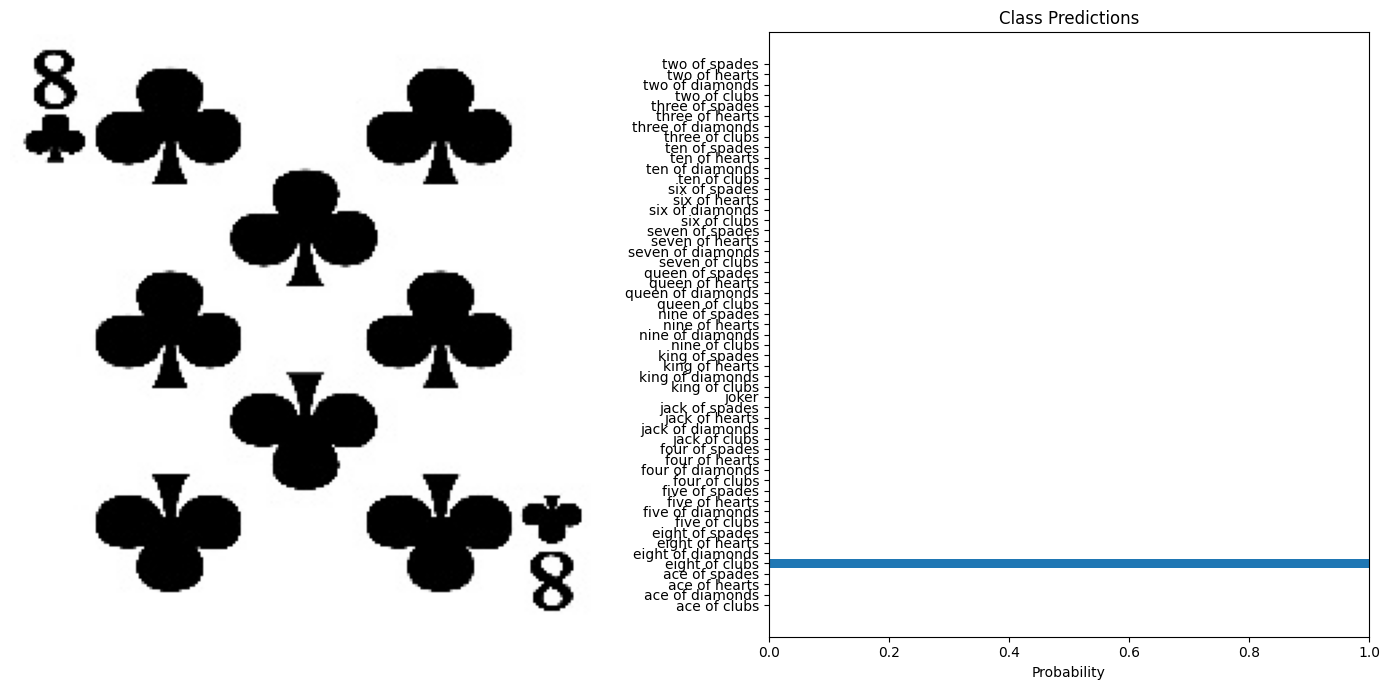

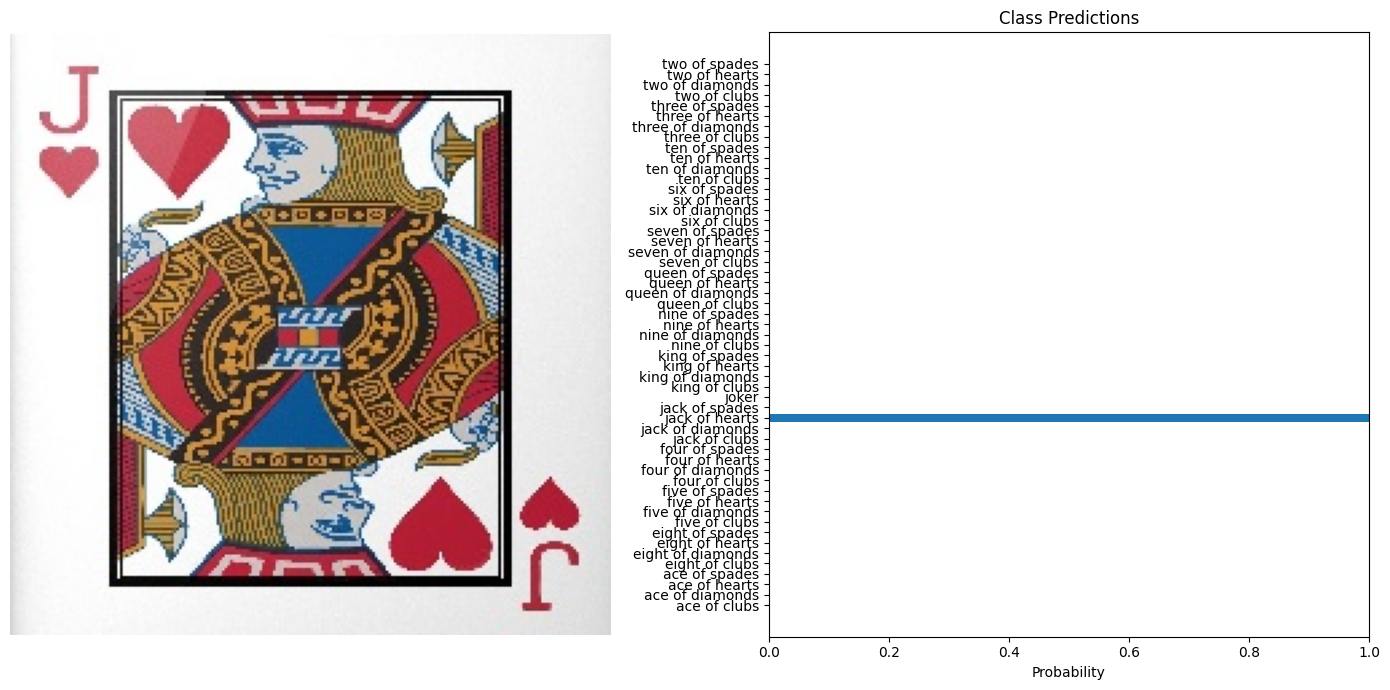

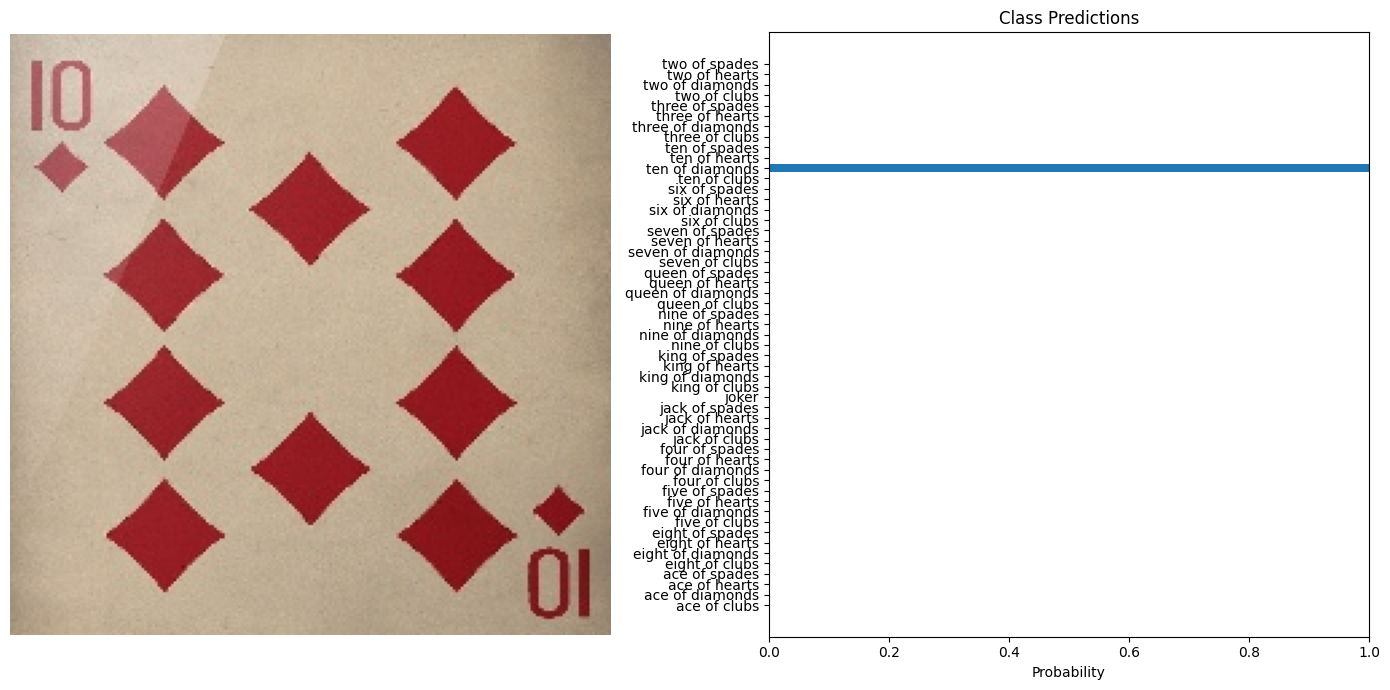

In [ ]:
from glob import glob
test_images = glob('/content/drive/MyDrive/data/test/*/*')
test_examples = np.random.choice(test_images, 10)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    probs = predict(model, image_tensor, device)

    class_names = dataset.classes
    visualize_pred(original_image, probs, class_names)

In [ ]:
#SVM Model
# Extract features using the penultimate layer of your deep learning model
def extract_features(model, dataloader, device):
    model.eval()
    features_list = []
    labels_list = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Extracting Features'):
            images, labels = images.to(device), labels.to(device)
            # Use the penultimate layer's output as features
            features = model.base_model(images).detach().cpu().numpy()
            features_list.append(features)
            labels_list.append(labels.cpu().numpy())

    features = np.concatenate(features_list)
    features = features.reshape(features.shape[0], -1)  # Flatten the features
    labels = np.concatenate(labels_list)
    return features, labels

# Train and validate SVM
def train_and_validate_svm(train_features, train_labels, val_features, val_labels):
    svm_classifier = svm.SVC()
    svm_classifier.fit(train_features, train_labels)

    # Predictions on the validation set
    val_predictions = svm_classifier.predict(val_features)
    val_accuracy = accuracy_score(val_labels, val_predictions)

    return val_accuracy

# Extract features from the training and validation sets
train_features, train_labels = extract_features(model, train_loader, device)
val_features, val_labels = extract_features(model, val_loader, device)

# Train and validate SVM
val_accuracy = train_and_validate_svm(train_features, train_labels, val_features, val_labels)

print(f"Validation Accuracy using SVM: {val_accuracy:.4f}")

Extracting Features: 100%|██████████| 9/9 [00:01<00:00,  8.45it/s]


Validation Accuracy using SVM: 1.0000
